In [ ]:
%%capture

!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset (1).csv


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.patches as mpatches
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve

In [ ]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [ ]:
def wrangle(df):
    df.drop(columns=['time'], inplace=True)
    df[df['ejection_fraction']>=70]
    return df
df = wrangle(df)

In [ ]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 28.2 KB


In [ ]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
DEATH_EVENT                 0
dtype: int64

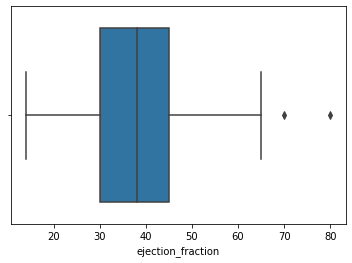

In [ ]:
sns.boxplot(x=df.ejection_fraction)
plt.show()

In [ ]:
df[df['ejection_fraction']>=70]

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
64,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,0
217,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,1


In [ ]:
# Get Pandas Profiling Report
report = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

SPLIT DATA

In [ ]:
target = 'DEATH_EVENT'
y = target
X = df.drop(columns=target)

#target distribution
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [ ]:
df['DEATH_EVENT'].value_counts(normalize=True)

0    0.67893
1    0.32107
Name: DEATH_EVENT, dtype: float64

Training & Validation Split

In [ ]:
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state =42)

Establishing Baseline
Since this is a classification problem I will be using accuracy

In [ ]:
y_train.value_counts(normalize=True)

0    0.702929
1    0.297071
Name: DEATH_EVENT, dtype: float64

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.702928870292887


Fitting Logistic Regression 

In [ ]:
heart_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression(max_iter=100))
heart_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
lr_acc = accuracy_score(y_train, heart_lr.predict(X_train))
lr_val = accuracy_score(y_val, heart_lr.predict(X_val))
print('heart_lr accuracy score for training', accuracy_score(y_train, heart_lr.predict(X_train)))
print('heart_lr accuracy score for validation', accuracy_score(y_val, heart_lr.predict(X_val)))

heart_lr accuracy score for training 0.7824267782426778
heart_lr accuracy score for validation 0.65


In [ ]:
y_pred = heart_lr.predict(X_val)
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1])

Gradient Boost 

In [ ]:
heart_gb = make_pipeline(
    OrdinalEncoder(),
    GradientBoostingClassifier(random_state=42, n_estimators=25))
heart_gb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=25, random_state=42))])

In [ ]:
gb_acc = heart_gb.score(X_train, y_train)
gb_val = heart_gb.score(X_val, y_val)
print('heart_gb accuracy score for training', heart_gb.score(X_train, y_train))
print('heart_gb accuracy score for validation', heart_gb.score(X_val, y_val))

heart_gb accuracy score for training 0.8828451882845189
heart_gb accuracy score for validation 0.65


Random Forest

In [ ]:
heart_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(max_depth = 3, criterion = 'gini', n_estimators = 200, random_state=0))

heart_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, n_estimators=200,
                                        random_state=0))])

In [ ]:
rf_acc = heart_rf.score(X_train, y_train)
rf_val = heart_rf.score(X_val, y_val)
print('heart_rf accuracy score for training', heart_rf.score(X_train, y_train))
print('heart_rf accuracy score for validation', heart_rf.score(X_val, y_val))

heart_rf accuracy score for training 0.8368200836820083
heart_rf accuracy score for validation 0.7


Decision Tree

In [ ]:
for leaves in range(2,10):
    heart_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=42, 
                                      criterion='gini')) 
heart_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_leaf_nodes=9, random_state=42))])

In [ ]:
dt_acc = heart_dt.score(X_train, y_train)
dt_val = heart_dt.score(X_val, y_val)
print('heart_rf accuracy score for training', heart_dt.score(X_train, y_train))
print('heart_rf accuracy score for validation', heart_dt.score(X_val, y_val))

heart_rf accuracy score for training 0.8451882845188284
heart_rf accuracy score for validation 0.65


In [ ]:
param_grid = {
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': range(2, 3, 4),
    'randomforestclassifier__n_estimators': range(100, 200, 300)}

HEART_rfgs = GridSearchCV(
    heart_rf,
    param_grid = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1)
HEART_rfgs.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=[], mapping=[])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(max_depth=3,
                                                               n_estimators=200,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': range(2, 3, 4),
                         'randomforestclassifier__n_estimators': range(100, 200, 300)},
             verbose=1)

In [ ]:
HEART_rfgs.predict(X_val)

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [ ]:
HEART_rfgs.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 2,
 'randomforestclassifier__n_estimators': 100}

In [ ]:
HEART_rfgs.best_score_

0.7324858757062147

In [ ]:
data = {'Model': ['Logistic Regression', 'GradientBoost', 'RandomForest', 'DecisionTree'],
        'Test Accuracy': [0.65, 0.65, 0.7, 0.65],
        'Training Accuracy': [0.78, 0.88, 0.83, 0.84],}
scores = pd.DataFrame(data)    
scores.head()    

,Model,Test Accuracy,Training Accuracy
0,Logistic Regression,0.65,0.78
1,GradientBoost,0.65,0.88
2,RandomForest,0.70,0.83
3,DecisionTree,0.65,0.84


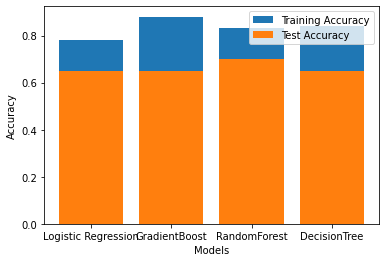

In [ ]:
w=0.8
x = scores['Model']
T = scores['Training Accuracy']
V = scores['Test Accuracy']
plt.bar(x,T,w,label='Training Accuracy')
plt.bar(x,V,w,label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

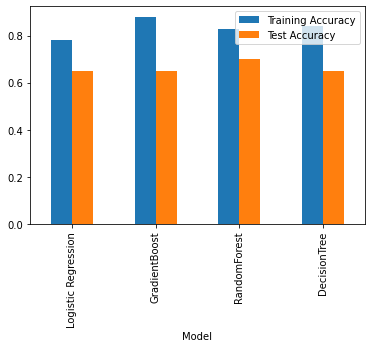

In [ ]:
scores.plot(x = 'Model', y = ['Training Accuracy', 'Test Accuracy'], kind = 'bar')

In [ ]:
heart_cr = classification_report(y_val, HEART_rfgs.predict(X_val))
print(heart_cr)

              precision    recall  f1-score   support

           0       0.67      0.97      0.79        35
           1       0.89      0.32      0.47        25

    accuracy                           0.70        60
   macro avg       0.78      0.65      0.63        60
weighted avg       0.76      0.70      0.66        60



In [ ]:
heart_cr = classification_report(y_val, heart_rf.predict(X_val))
print(heart_cr)

              precision    recall  f1-score   support

           0       0.67      0.94      0.79        35
           1       0.82      0.36      0.50        25

    accuracy                           0.70        60
   macro avg       0.75      0.65      0.64        60
weighted avg       0.73      0.70      0.67        60



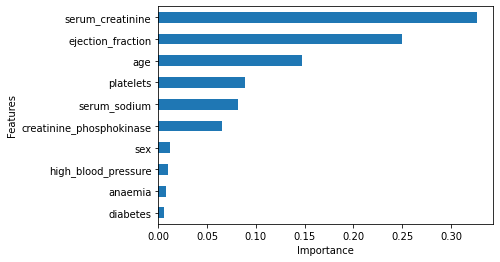

In [ ]:
gini = heart_rf.named_steps['randomforestclassifier'].feature_importances_
features = heart_rf.named_steps['ordinalencoder'].get_feature_names()
pd.Series(data=gini, index=features).sort_values().tail(10).plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Importance');

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fba497b7090>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fba498e1cd0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


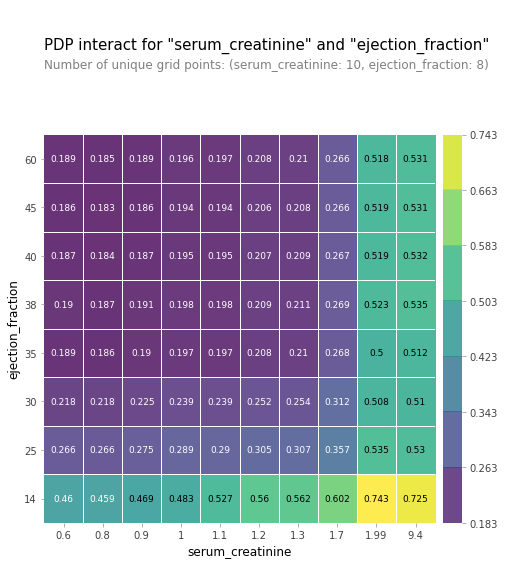

In [ ]:
features = ['serum_creatinine', 'ejection_fraction']
interact = pdp_interact(heart_rf, dataset=X_val, 
                        model_features = X_val.columns, features = features)

pdp_interact_plot(interact, plot_type='grid', feature_names=features)